# Librerias

In [1]:
#tenemos que agregar al sys path el directorio
import sys
AssDis_path="/home/asirvent/extra_repos/Anomaly-Transformer"
sys.path.append(AssDis_path)

In [3]:

import numpy as np 
import torch
import matplotlib.pyplot as plt 
import time
from torch import nn

import os
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import collections
import numbers
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle

from model.AnomalyTransformer import AnomalyTransformer


## variables




In [4]:
BASE_dir="/home/asirvent/extra_repos/TFM/1-AnomalyTranformer_MIO/ejecucion_remota"
dataset_name="PSM"

datapath=f"{BASE_dir}/data/{dataset_name}"
model_save_path=f"{BASE_dir}/results_y_models/1-PSM_models"

if (not os.path.exists(model_save_path)):
    os.mkdir(model_save_path)



# Entrenamiento

## Definimos funciones relevantes


In [5]:

#funcion para ocntar los parametros del modelo 
def count_parameters(model):
    total=sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total}")
    return total


In [6]:

class PSMSegLoader(object): ##y esto no deberia heredar de dataset?
    def __init__(self, data_path, win_size, step, mode="train"):
        self.mode = mode
        self.step = step
        self.win_size = win_size
        self.scaler = StandardScaler()
        data = pd.read_csv(data_path + '/train.csv')
        data = data.values[:, 1:]

        data = np.nan_to_num(data)

        self.scaler.fit(data)
        data = self.scaler.transform(data)
        test_data = pd.read_csv(data_path + '/test.csv')

        test_data = test_data.values[:, 1:]
        test_data = np.nan_to_num(test_data)

        self.test = self.scaler.transform(test_data)

        self.train = data
        self.val = self.test

        self.test_labels = pd.read_csv(data_path + '/test_label.csv').values[:, 1:] ## y los labels de train ?

        print("test:", self.test.shape)
        print("train:", self.train.shape)

    def __len__(self):
        """
        Number of images in the object dataset.
        """
        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif (self.mode == 'val'):
            return (self.val.shape[0] - self.win_size) // self.step + 1
        elif (self.mode == 'test'):
            return (self.test.shape[0] - self.win_size) // self.step + 1
        else:
            return (self.test.shape[0] - self.win_size) // self.win_size + 1

    def __getitem__(self, index):
        index = index * self.step
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.mode == 'val'):
            return np.float32(self.val[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.mode == 'test'):
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])
        else:
            return np.float32(self.test[
                              index // self.step * self.win_size:index // self.step * self.win_size + self.win_size]), np.float32(
                self.test_labels[index // self.step * self.win_size:index // self.step * self.win_size + self.win_size])



def get_loader_segment(data_path, batch_size, win_size=100, step=100, mode='train', dataset='KDD'):
    # if (dataset == 'SMD'):
    #     dataset = SMDSegLoader(data_path, win_size, step, mode)
    # elif (dataset == 'MSL'):
    #     dataset = MSLSegLoader(data_path, win_size, 1, mode)
    # elif (dataset == 'SMAP'):
    #     dataset = SMAPSegLoader(data_path, win_size, 1, mode)
    # elif (dataset == 'PSM'):

    dataset = PSMSegLoader(data_path, win_size, 1, mode)

    shuffle = False
    if mode == 'train':
        shuffle = True

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=0)
    return data_loader



class EarlyStopping:
    def __init__(self, patience=7, verbose=False, dataset_name='', delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.best_score2 = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_loss2_min = np.Inf
        self.delta = delta
        self.dataset = dataset_name

    def __call__(self, val_loss, val_loss2, model, path):
        score = -val_loss
        score2 = -val_loss2
        if self.best_score is None:
            self.best_score = score
            self.best_score2 = score2
            self.save_checkpoint(val_loss, val_loss2, model, path)
        elif score < self.best_score + self.delta or score2 < self.best_score2 + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_score2 = score2
            self.save_checkpoint(val_loss, val_loss2, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, val_loss2, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), os.path.join(path, str(self.dataset) + '_checkpoint.pth'))
        self.val_loss_min = val_loss
        self.val_loss2_min = val_loss2



#para el modelo en sí

def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)


def adjust_learning_rate(optimizer, epoch, lr_):
    lr_adjust = {epoch: lr_ * (0.5 ** ((epoch - 1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))
        


## Carga de datos

In [7]:
train_loader = get_loader_segment(datapath, batch_size=64, win_size=100,mode='train',dataset=dataset_name)
vali_loader = get_loader_segment(datapath, batch_size=64, win_size=100,mode='val',dataset=dataset_name)

test: (87841, 25)
train: (132481, 25)
test: (87841, 25)
train: (132481, 25)


## Crear modelo

In [8]:
win_size=100
model=AnomalyTransformer(win_size=win_size, enc_in=25, c_out=25, e_layers=3, d_model=128, n_heads=4)
_=count_parameters(model)

/home/asirvent/pytorch_env/lib64/python3.6/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


Total trainable parameters: 610213


## Entrenamiento

In [9]:
def vali(vali_loader):
    model.eval()

    loss_1 = []
    loss_2 = []
    for i, (input_data, _) in enumerate(vali_loader):
        input = input_data.float().to(device)
        output, series, prior, _ = model(input)
        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)): ##esta es la long L de la serie
            series_loss += (torch.mean(my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach())) + torch.mean(
                my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach(),
                    series[u])))
            prior_loss += (torch.mean(
                my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                    win_size)),
                            series[u].detach())) + torch.mean(
                my_kl_loss(series[u].detach(),
                            (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                    win_size)))))
        series_loss = series_loss / len(prior)
        prior_loss = prior_loss / len(prior)

        rec_loss = criterion(output, input)
        loss_1.append((rec_loss - k * series_loss).item())
        loss_2.append((rec_loss + k * prior_loss).item())

    return np.average(loss_1), np.average(loss_2) ##esto es np.mean pero fancy


In [11]:

criterion = nn.MSELoss()
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr=1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

early_stopping = EarlyStopping(patience=3, verbose=True, dataset_name=dataset_name)

train_steps = len(train_loader)
k=3
num_epochs=10
time_now = time.time()

for epoch in range(num_epochs):
    iter_count = 0
    loss1_list = []

    epoch_time = time.time()
    model.train()
    for i, (input_data, labels) in enumerate(train_loader):
        #print(input_data.shape)

        optimizer.zero_grad()
        iter_count += 1
        input = input_data.float().to(device)

        output, series, prior, sigmas = model(input_data)

        # calculate Association discrepancy
        series_loss = 0.0 ##con prior y series loss hace referencia al los por el que se entrena cada una de ellas. Y las calcula por separado porque tiene 
                            ##que incluir el detach
        prior_loss = 0.0
        for u in range(len(prior)):
            series_loss += (torch.mean(my_kl_loss(series[u], 
                                                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,win_size)).detach())) + 
                            torch.mean(my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,win_size)).detach(),
                                                    series[u])))
            
            prior_loss += (torch.mean(my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach())) + torch.mean(
                my_kl_loss(series[u].detach(), (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                win_size)))))
        series_loss = series_loss / len(prior)
        prior_loss = prior_loss / len(prior)

        rec_loss = criterion(output, input)

        loss1_list.append((rec_loss - k * series_loss).item())
        loss1 = rec_loss - k * series_loss
        loss2 = rec_loss + k * prior_loss

        if (i + 1) % 100 == 0:
            speed = (time.time() - time_now) / iter_count
            left_time = speed * ((num_epochs - epoch) * train_steps - i)
            print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            time_now = time.time()

        # Minimax strategy
        loss1.backward(retain_graph=True) ##importante porque sino se borran los gradientes de las variables
        loss2.backward()
        optimizer.step()

    print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
    train_loss = np.average(loss1_list)


    vali_loss1, vali_loss2 = vali(vali_loader)

    print(
        "Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} ".format(
            epoch + 1, train_steps, train_loss, vali_loss1))
    

    early_stopping(vali_loss1, vali_loss2,model, model_save_path)
    if early_stopping.early_stop:
        print("Early stopping")
        break


    adjust_learning_rate(optimizer, epoch + 1, lr)


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Analisis resultados 

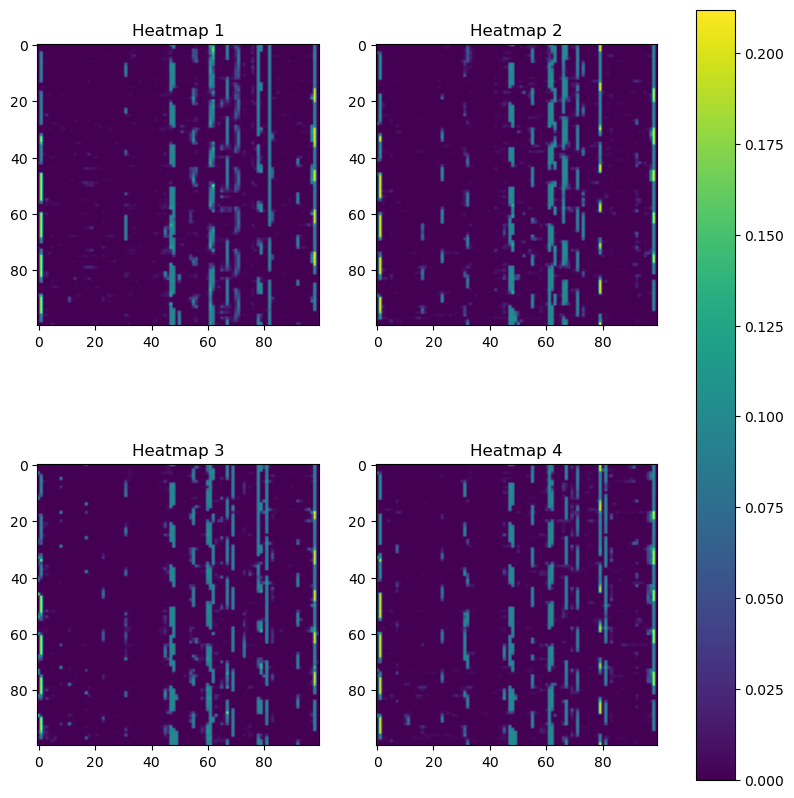

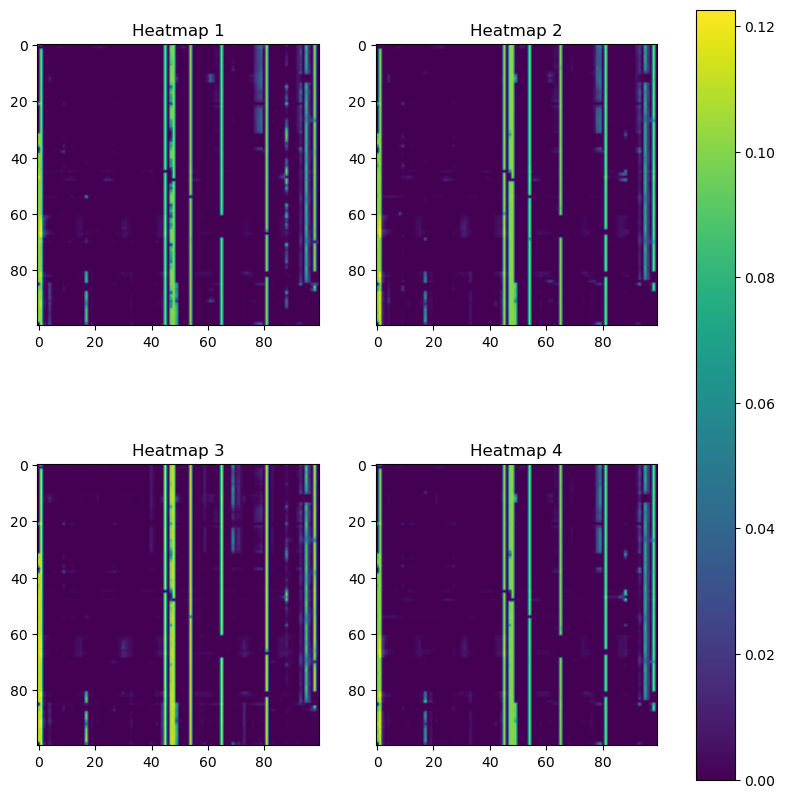

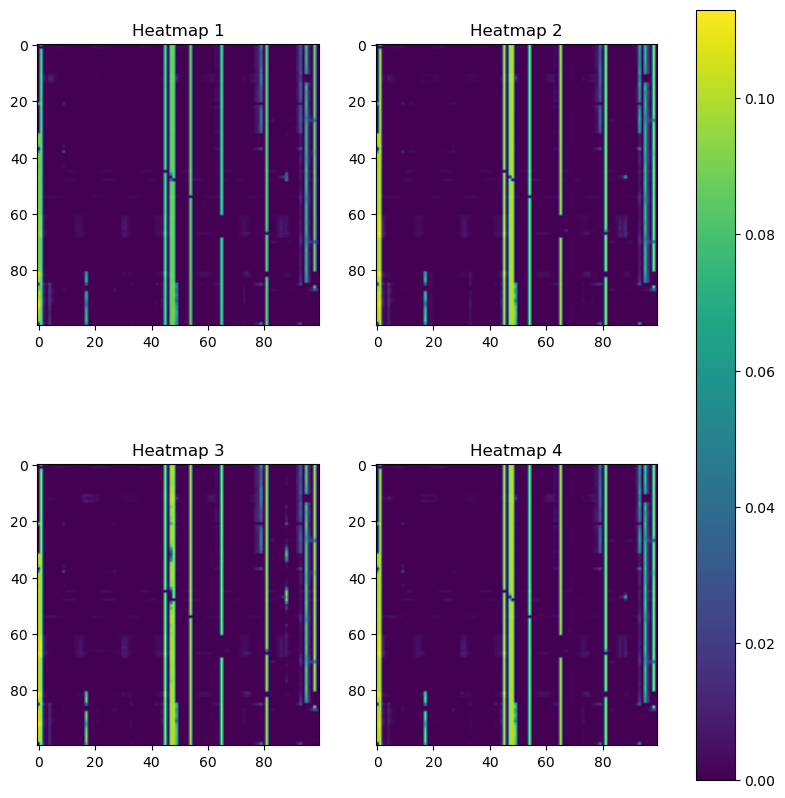

In [34]:
for j in [0,1,2]:
    array=series[j][:].detach().numpy().mean(axis=0)
    # Crear subplot de 2 filas y 2 columnas
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    # Crear mapa de calor para cada gráfico en el subplot
    for i, ax in enumerate(axs.flat):
        heatmap = ax.imshow(array[i], cmap='viridis')
        ax.set_title(f'Heatmap {i+1}')

    # Agregar barra de color compartida
    fig.colorbar(heatmap, ax=axs.ravel().tolist())



In [31]:
x=next(iter(train_loader))[0]

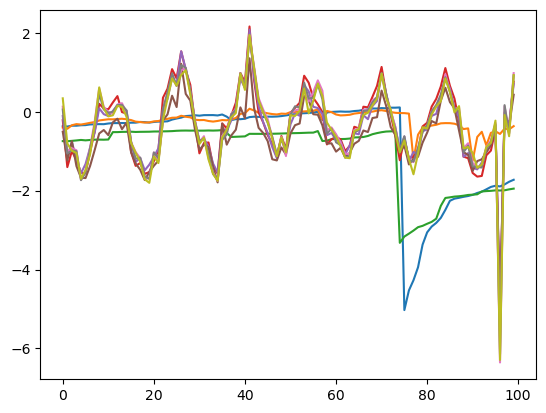

In [35]:
for i in [1,2,3,4,5,7,8,9,10]:
    plt.plot(x[1,:,i])